Julio B. Roll - PS4

Matching US income distribution and the Brock and Mirman model by GMM.

### 1) US Income Distribution

### Question a)

Let's plot the histogram for the income data. We will import some packages and our data as well.

In [260]:
# importing our data series
import numpy as np
import scipy.stats as sts
import matplotlib.pyplot as plt
import scipy.optimize as opt
import scipy.special as spc
import scipy.integrate as intgr
import numpy.linalg as lin
import distribs

income_data = np.loadtxt('usincmoms.txt', delimiter = '\t')
hh_perc = income_data[:,0]
mid_pts = income_data[:,1]      

<IPython.core.display.Javascript object>


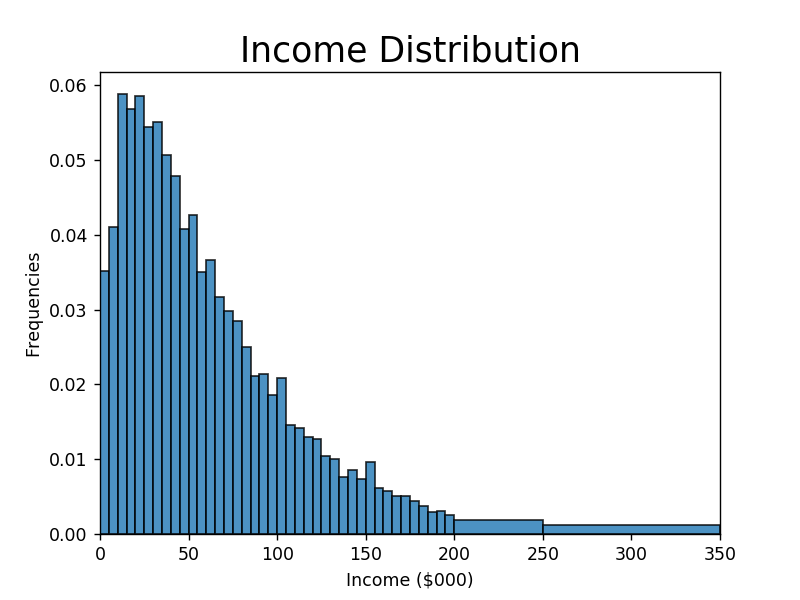

Text(0,0.5,'Frequencies')

In [65]:
%matplotlib notebook
plt.figure(0)
plt.bar(mid_pts/1000, height = np.append(hh_perc[0:40], [hh_perc[40]/10, hh_perc[41]/20]),
        width = np.append([5] * 40, [50, 100]), edgecolor='black', alpha = 0.8)
plt.title('Income Distribution', fontsize=20)
plt.xlim([0, 350])
plt.xlabel('Income ($000)')
plt.ylabel('Frequencies')

### Question b)

We will use GMM to fit a LN distribution (called from our distribs.py) to the data using our 42 moments.

Let's define a criterion function using the moments:

($\textbf{NB:}$ for the integrals, I've ran into an interesting issue related to the size of each percentile: as they became smaller, especifically the very last one, the intr.quad had some trouble distinguishing the integrand from the error. I've tried adjusting the error term, forcing the .quad to only use the relative one, without success. Since the problem is only on the very last interval, we can patch it with an indirect calculation).

In [185]:
def model_moments_ln(mu, sigma):
    '''
    --------------------------------------------------------------------
    This function computes the 42 model moments for GMM with a LN 
    distribution.
    --------------------------------------------------------------------
    INPUTS:
    mu     = scalar, mean of the log-normally distributed random variable
    sigma  = scalar > 0, standard deviation of the log-normally distributed
             random variable
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        distribs.ln_norm_pdf
        cdf()
    
    OBJECTS CREATED WITHIN FUNCTION:
    mod_m      = array, percentiles of the distribution according to the
                 income class
    m_m_err    = array > 0, estimated error in the computation of the
                 integral for the income classes of the distribution
    m          = auxiliary variable
    err        = auxiliary variable
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: mod_m
    --------------------------------------------------------------------
    '''
    cdf = lambda x: distribs.ln_norm_pdf(x, mu, sigma)
    
    mod_m = []
    m_m_err = []
    (m, err) = intgr.quad(cdf, 0.0000001, 5000, epsabs=0)
    mod_m.append(m)
    m_m_err.append(err)
    
    for i in range(1, 40):
        (m, err) = intgr.quad(cdf, i * 5000, i * 5000 + 4999, epsabs=0)
        mod_m.append(m)
        m_m_err.append(err)
        
    (m, err) = intgr.quad(cdf, 200000, 250000, epsabs=0)
    mod_m.append(m)
    m_m_err.append(err)
    
#    (m, err) = intgr.quad(cdf, 250000, np.inf, epsabs=0)
#    mod_m.append(m)
#    m_m_err.append(err)
    mod_m.append(1 - np.sum(mod_m))
    
    return mod_m


def err_vec_ln(moms_data, mu, sigma, simple):
    '''
    --------------------------------------------------------------------
    This function computes the vector of moment errors (in percent
    deviation from the data moment vector) for GMM.
    --------------------------------------------------------------------
    INPUTS:
    moms_data  = (42,1) matrix, data moments (pre-calculated)
    mu         = scalar, mean of the log-normally distributed random variable
    sigma      = scalar > 0, standard deviation of the log-normally distributed
                 random variable
    simple     = boolean, =True if errors are simple difference, =False if
                 errors are percent deviation from data moments
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        model_moments()
    
    OBJECTS CREATED WITHIN FUNCTION:
    moms_model = (42, 1) matrix, column vector of the 42 model moments
    err_vec    = (42, 1) matrix, column vector of the 42 moment error
                 functions
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: err_vec
    --------------------------------------------------------------------
    '''
    moms_model = model_moments_ln(mu, sigma)
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec


def criterion_ln(params, *args):
    '''
    --------------------------------------------------------------------
    This function computes the GMM weighted sum of squared moment errors
    criterion function value given parameter values and an estimate of
    the weighting matrix.
    --------------------------------------------------------------------
    INPUTS:
    params     = (2,) vector, ([mu, sigma])
    mu         = scalar, mean of the log-normally distributed random variable
    sigma      = scalar > 0, standard deviation of the log-normally distributed
                 random variable
    args       = length 2 tuple, (moms_data, W_hat)
    moms_data  = (42,1) matrix, data moments (pre-calculated)
    W_hat      = (R, R) matrix, estimate of optimal weighting matrix
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        distribs.ln_norm_pdf()
    
    OBJECTS CREATED WITHIN FUNCTION:
    err        = (42, 1) matrix, column vector of two moment error
                 functions
    crit_val   = scalar > 0, GMM criterion function value
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: crit_val
    --------------------------------------------------------------------
    '''
    mu, sigma = params
    moms_data, W = args
    err = err_vec_ln(moms_data, mu, sigma, simple=False)
    crit_val = np.dot(np.dot(err.T, W), err) 
    
    return crit_val

Estimation routine: we will use the suggested W matrix using the data moments. $\mu_{init}$ as suggested as well.

In [190]:
# This can take a little while
mu_init = np.log(69677)
sig_init = mu_init
params_init = np.array([mu_init, sig_init])
W_hat = np.eye(42) * hh_perc
gmm_args = (hh_perc, W_hat)
results1 = opt.minimize(criterion_ln, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM_LN, sig_GMM_LN = results1.x
print('mu_init=', mu_init, ' sig_init=', sig_init)
print('mu_GMM_GA=', mu_GMM_LN, ' sig_GMM_GA=', sig_GMM_LN)

mu_init= 11.1516255566  sig_init= 11.1516255566
mu_GMM_GA= 10.7665617092  sig_GMM_GA= 0.907362222162


In [163]:
results1

      fun: 0.046099179134464992
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -1.67851844e-06,  -2.52575738e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 75
      nit: 13
   status: 0
  success: True
        x: array([ 10.76656171,   0.90736222])

In [302]:
m_model_LN = model_moments(mu_GMM_LN, sig_GMM_LN)
err_LN = err_vec_ln(hh_perc, mu_GMM_LN, sig_GMM_LN, False).reshape(42,)
print('Data moments =', hh_perc)
print('Model moments =', m_model_LN)
print('Error vector=', err_LN)

Data moments = [ 0.03519016  0.04106206  0.05885948  0.05683611  0.0585952   0.05443284
  0.0550605   0.05067515  0.04785894  0.04083908  0.04269728  0.03509931
  0.03660239  0.03168022  0.02978073  0.0285089   0.0250733   0.02119173
  0.02142297  0.01859025  0.02086964  0.01462609  0.01422967  0.01295784
  0.01271834  0.0103894   0.01000124  0.00758145  0.00851468  0.00737498
  0.0096296   0.00611141  0.00575629  0.00503778  0.00509559  0.00437709
  0.00379898  0.00299789  0.00313829  0.0025767   0.01897015  0.02319032]
Model moments = [0.006587207703846514, 0.036565695284429045, 0.05917938713649551, 0.06838439760195059, 0.06955513948426228, 0.06667946686452378, 0.06199672580313653, 0.05668768282564557, 0.051354395698990786, 0.04628933038722686, 0.04162033035463874, 0.03738849797022743, 0.03359028241805262, 0.030200336238663004, 0.027183915642004862, 0.024503531553121554, 0.022122414460855125, 0.02000620893555351, 0.01812368944809901, 0.01644694397854237, 0.014951278342398983, 0.01361

<IPython.core.display.Javascript object>


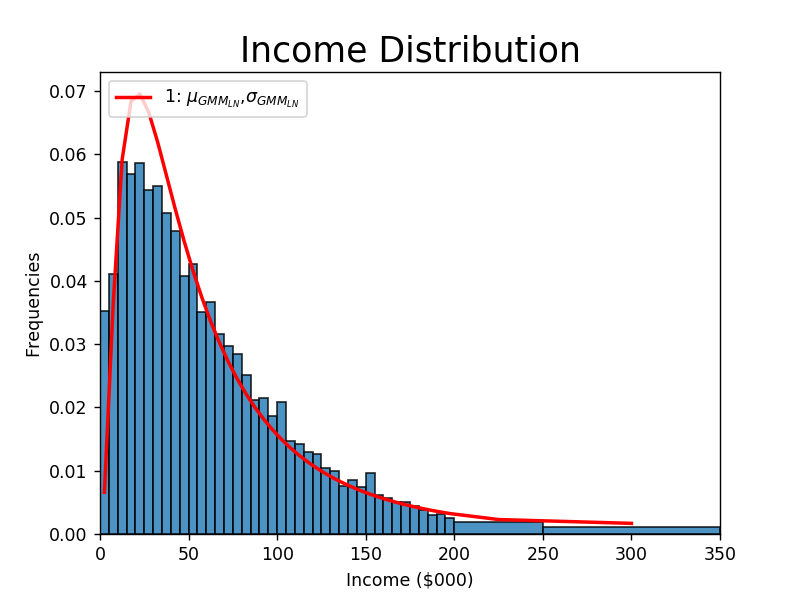

In [193]:
# Plot the histogram of the data
plt.figure(1)
plt.bar(mid_pts/1000, height = np.append(hh_perc[0:40], [hh_perc[40]/10, hh_perc[41]/20]),
        width = np.append([5] * 40, [50, 100]), edgecolor='black', alpha = 0.8)
plt.title('Income Distribution', fontsize=20)
plt.xlim([0, 350])
plt.xlabel('Income ($000)')
plt.ylabel('Frequencies')

# Plot the estimated GMM PDF
plt.plot(mid_pts/1000, np.append(m_model_LN[0:40], [m_model_LN[40]/10, m_model_LN[41]/20]),
         linewidth=2, color='r', label='1: $\mu_{GMM_{LN}}$,$\sigma_{GMM_{LN}}$')
plt.legend(loc='upper left')

Estimation looks good, especially in the downard curvature and the tail. However, we overshoot on the peak.

### Question c)

Let's estimate again using the GA distribution and the previous W matrix. We'll call the distribution from distribs.py. The functions are similar to the previous ones.

In [220]:
def model_moments_ga(alpha, beta):
    '''
    --------------------------------------------------------------------
    This function computes the 42 model moments for GMM using a GA
    distribution.
    --------------------------------------------------------------------
    INPUTS:
    alpha    = scalar > 0, shape
    beta     = scalar > 0, rate
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        distribs.gamma_pdf
        cdf()
    
    OBJECTS CREATED WITHIN FUNCTION:
    mod_m      = array, percentiles of the distribution according to the
                 income class
    m_m_err    = array > 0, estimated error in the computation of the
                 integral for the income classes of the distribution
    m          = auxiliary variable
    err        = auxiliary variable
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: mod_m
    --------------------------------------------------------------------
    '''
    cdf = lambda x: distribs.gamma_pdf(x, alpha, beta)
    
    mod_m = []
    m_m_err = []
    (m, err) = intgr.quad(cdf, 0.0000001, 5000, epsabs=0)
    mod_m.append(m)
    m_m_err.append(err)
    
    for i in range(1, 40):
        (m, err) = intgr.quad(cdf, i * 5000, i * 5000 + 4999, epsabs=0)
        mod_m.append(m)
        m_m_err.append(err)
        
    (m, err) = intgr.quad(cdf, 200000, 250000, epsabs=0)
    mod_m.append(m)
    m_m_err.append(err)
    
#    (m, err) = intgr.quad(cdf, 250000, np.inf, epsabs=0)
#    mod_m.append(m)
#    m_m_err.append(err)
    mod_m.append(1 - np.sum(mod_m))
    
    return mod_m


def err_vec_ga(moms_data, alpha, beta, simple):
    '''
    --------------------------------------------------------------------
    This function computes the vector of moment errors (in percent
    deviation from the data moment vector) for GMM.
    --------------------------------------------------------------------
    INPUTS:
    moms_data  = (42,1) matrix, data moments (pre-calculated)
    alpha      = scalar > 0, shape
    beta       = scalar > 0, rate
    simple     = boolean, =True if errors are simple difference, =False if
                 errors are percent deviation from data moments
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        model_moments()
    
    OBJECTS CREATED WITHIN FUNCTION:
    moms_model = (42, 1) matrix, column vector of the 42 model moments
    err_vec    = (42, 1) matrix, column vector of the 42 moment error
                 functions
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: err_vec
    --------------------------------------------------------------------
    '''
    moms_model = model_moments_ga(alpha, beta)
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec


def criterion_ga(params, *args):
    '''
    --------------------------------------------------------------------
    This function computes the GMM weighted sum of squared moment errors
    criterion function value given parameter values and an estimate of
    the weighting matrix.
    --------------------------------------------------------------------
    INPUTS:
    params     = (2,) vector, ([alpha, beta])
    alpha      = scalar > 0, shape
    beta       = scalar > 0, rate
    args       = length 2 tuple, (moms_data, W_hat)
    moms_data  = (42,1) matrix, data moments (pre-calculated)
    W_hat      = (R, R) matrix, estimate of optimal weighting matrix
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        distribs.gamma_pdf()
    
    OBJECTS CREATED WITHIN FUNCTION:
    err        = (42, 1) matrix, column vector of two moment error
                 functions
    crit_val   = scalar > 0, GMM criterion function value
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: crit_val
    --------------------------------------------------------------------
    '''
    alpha, beta = params
    moms_data, W = args
    err = err_vec_ga(moms_data, alpha, beta, simple=False)
    crit_val = np.dot(np.dot(err.T, W), err) 
    
    return crit_val

Estimation routine: similar to the previous one.

In [252]:
# This can take a little while
alpha_init = 3
beta_init = 20000
params_init = np.array([alpha_init, beta_init])
W_hat = np.eye(42) * hh_perc
gmm_args = (hh_perc, W_hat)
results2 = opt.minimize(criterion_ga, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
alpha_GMM_GA, beta_GMM_GA = results2.x
print('alpha_init=', alpha_init, ' beta_init=', beta_init)
print('alpha_GMM_GA=', alpha_GMM_GA, ' beta_GMM_GA=', beta_GMM_GA)

alpha_init= 3  beta_init= 20000
alpha_GMM_GA= 1.36290278284  beta_GMM_GA= 48295.4442177


In [250]:
results2

      fun: 0.31733061552969438
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([  1.05471187e-07,  -3.23352456e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 33
      nit: 5
   status: 0
  success: True
        x: array([  1.88981329e+00,   2.00000000e+04])

In [303]:
m_model_GA = model_moments_ga(alpha_GMM_GA, beta_GMM_GA)
err_GA = err_vec_ga(hh_perc, alpha_GMM_GA, beta_GMM_GA, False).reshape(42,)
print('Data moments =', hh_perc)
print('Model moments =', m_model_GA)
print('Error vector=', err_GA)

Data moments = [ 0.03519016  0.04106206  0.05885948  0.05683611  0.0585952   0.05443284
  0.0550605   0.05067515  0.04785894  0.04083908  0.04269728  0.03509931
  0.03660239  0.03168022  0.02978073  0.0285089   0.0250733   0.02119173
  0.02142297  0.01859025  0.02086964  0.01462609  0.01422967  0.01295784
  0.01271834  0.0103894   0.01000124  0.00758145  0.00851468  0.00737498
  0.0096296   0.00611141  0.00575629  0.00503778  0.00509559  0.00437709
  0.00379898  0.00299789  0.00313829  0.0025767   0.01897015  0.02319032]
Model moments = [0.03532209780674903, 0.0503506378665857, 0.054848660260422254, 0.05594045216773165, 0.05528362158201557, 0.053627274149885405, 0.051384283407500016, 0.048806163635259095, 0.04605502982461308, 0.0432387696713323, 0.04043031337904214, 0.0376790827943278, 0.035018214195297374, 0.032469326705431165, 0.030045782441567935, 0.027754976833225628, 0.025599981961150903, 0.023580745082420283, 0.0216949736482355, 0.019938794781296797, 0.018307249725161838, 0.01679

<IPython.core.display.Javascript object>


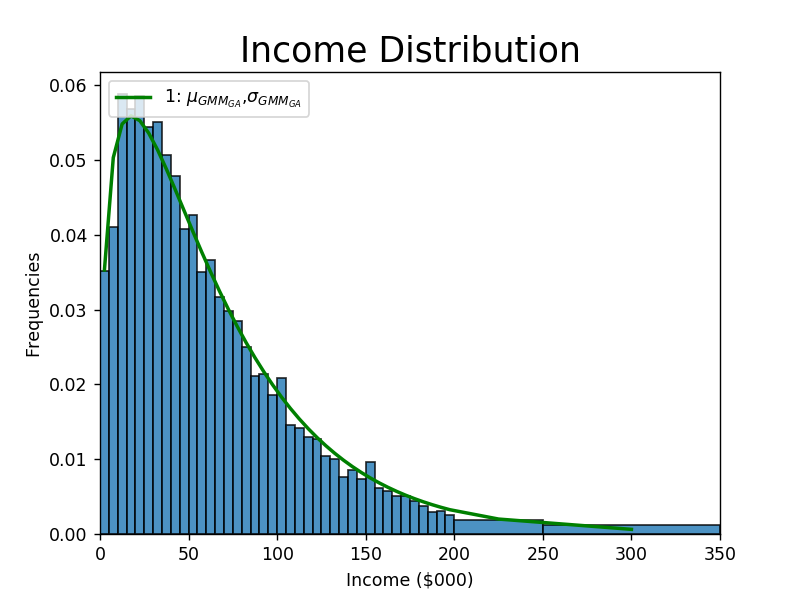

In [255]:
# Plot the histogram of the data
plt.figure(2)
plt.bar(mid_pts/1000, height = np.append(hh_perc[0:40], [hh_perc[40]/10, hh_perc[41]/20]),
        width = np.append([5] * 40, [50, 100]), edgecolor='black', alpha = 0.8)
plt.title('Income Distribution', fontsize=20)
plt.xlim([0, 350])
plt.xlabel('Income ($000)')
plt.ylabel('Frequencies')

# Plot the estimated GMM PDF
plt.plot(mid_pts/1000, np.append(m_model_GA[0:40], [m_model_GA[40]/10, m_model_GA[41]/20]),
         linewidth=2, color='g', label='1: $\mu_{GMM_{GA}}$,$\sigma_{GMM_{GA}}$')
plt.legend(loc='upper left')

Curvature looks great, but the tail "dies" for high incomes.

### Question d)

Let's plot everyone:

<IPython.core.display.Javascript object>


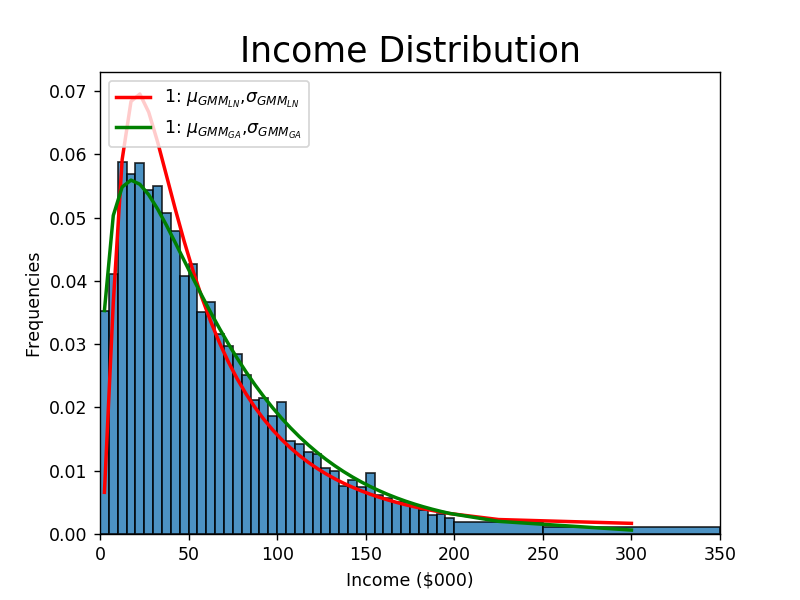

In [256]:
# Plot the histogram of the data
plt.figure(3)
plt.bar(mid_pts/1000, height = np.append(hh_perc[0:40], [hh_perc[40]/10, hh_perc[41]/20]),
        width = np.append([5] * 40, [50, 100]), edgecolor='black', alpha = 0.8)
plt.title('Income Distribution', fontsize=20)
plt.xlim([0, 350])
plt.xlabel('Income ($000)')
plt.ylabel('Frequencies')

# Plot the estimated GMM PDF
plt.plot(mid_pts/1000, np.append(m_model_LN[0:40], [m_model_LN[40]/10, m_model_LN[41]/20]),
         linewidth=2, color='r', label='1: $\mu_{GMM_{LN}}$,$\sigma_{GMM_{LN}}$')
plt.legend(loc='upper left')

# Plot the estimated GMM PDF
plt.plot(mid_pts/1000, np.append(m_model_GA[0:40], [m_model_GA[40]/10, m_model_GA[41]/20]),
         linewidth=2, color='g', label='1: $\mu_{GMM_{GA}}$,$\sigma_{GMM_{GA}}$')
plt.legend(loc='upper left')

Since the criterion function is the same (same calculation for the error and same W), we can compare the results from the minimization:

In [257]:
print('Results with LN: ', results1.fun)
print('Results with GA: ', results2.fun)

Results with LN:  0.0460991791345
Results with GA:  0.0121667190006


This suggests that the GA distribution fits the data better. Visually, it has a better downward curvature, peak and initial value (even if we could probably do better regarding its tail).

### Question e)

Let's repeat (c) with a two-step W. Since we already have have the results with the identity matrix I:

In [477]:
err_GA = np.array([err_vec_ga(hh_perc, alpha_GMM_GA, beta_GMM_GA, False)])
VCV2 = np.dot(err_GA.T, err_GA) / 121084
print(VCV2)
W_hat2 = lin.pinv(VCV2)  # Use the pseudo-inverse calculated by SVD because VCV2 is ill-conditioned
print(W_hat2)

[[  1.16100933e-10   7.00459031e-09  -2.11004199e-09 ...,   8.07930212e-09
    1.67545897e-09  -1.43576161e-08]
 [  7.00459031e-09   4.22600268e-07  -1.27302850e-07 ...,   4.87439677e-07
    1.01083629e-07  -8.66222312e-07]
 [ -2.11004199e-09  -1.27302850e-07   3.83483325e-08 ...,  -1.46834881e-07
   -3.04501324e-08   2.60938237e-07]
 ..., 
 [  8.07930212e-09   4.87439677e-07  -1.46834881e-07 ...,   5.62227374e-07
    1.16592855e-07  -9.99126494e-07]
 [  1.67545897e-09   1.01083629e-07  -3.04501324e-08 ...,   1.16592855e-07
    2.41786410e-08  -2.07195551e-07]
 [ -1.43576161e-08  -8.66222312e-07   2.60938237e-07 ...,  -9.99126494e-07
   -2.07195551e-07   1.77553388e-06]]
[[  2.68071705e+00   1.61732763e+02  -4.87198972e+01 ...,   1.86547363e+02
    3.86855757e+01  -3.31510740e+02]
 [  1.61732763e+02   9.75764545e+03  -2.93936414e+03 ...,   1.12547575e+04
    2.33397443e+03  -2.00006740e+04]
 [ -4.87198972e+01  -2.93936414e+03   8.85445327e+02 ...,  -3.39034974e+03
   -7.03079526e+02   

Routine: I'm using the previous values as initial ones here.

In [495]:
# This can take a little while
alpha_init = alpha_GMM_GA
beta_init = beta_GMM_GA
params_init = np.array([alpha_init, beta_init])
gmm_args = (hh_perc, W_hat2)
results3 = opt.minimize(criterion_ga, params_init, args=(gmm_args),
                       method='Nelder-Mead', tol = 1e-10)
#results3 = opt.minimize(criterion_ga, params_init, args=(gmm_args),
#                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)), tol = 1e-10)
alpha_GMM_GA2, beta_GMM_GA2 = results3.x
print('alpha_init=', alpha_init, ' beta_init=', beta_init)
print('alpha_GMM_GA2=', alpha_GMM_GA2, ' beta_GMM_GA2=', beta_GMM_GA2)

alpha_init= 1.36290278284  beta_init= 48295.4442177
alpha_GMM_GA2= 1.44726843981  beta_GMM_GA2= 37604.6238972


In [496]:
results3

 final_simplex: (array([[  1.44726844e+00,   3.76046239e+04],
       [  1.44726844e+00,   3.76046239e+04],
       [  1.44726844e+00,   3.76046239e+04]]), array([ -9.28496285e-12,   1.34987759e-12,   1.02495780e-11]))
           fun: -9.2849628539112133e-12
       message: 'Optimization terminated successfully.'
          nfev: 263
           nit: 110
        status: 0
       success: True
             x: array([  1.44726844e+00,   3.76046239e+04])

In [497]:
m_model_GA2 = model_moments_ga(alpha_GMM_GA2, beta_GMM_GA2)
err_GA2 = err_vec_ga(hh_perc, alpha_GMM_GA2, beta_GMM_GA2, False).reshape(42,)
print('Data moments =', hh_perc)
print('Model moments =', m_model_GA2)
print('Error vector=', err_GA2)

Data moments = [ 0.03519016  0.04106206  0.05885948  0.05683611  0.0585952   0.05443284
  0.0550605   0.05067515  0.04785894  0.04083908  0.04269728  0.03509931
  0.03660239  0.03168022  0.02978073  0.0285089   0.0250733   0.02119173
  0.02142297  0.01859025  0.02086964  0.01462609  0.01422967  0.01295784
  0.01271834  0.0103894   0.01000124  0.00758145  0.00851468  0.00737498
  0.0096296   0.00611141  0.00575629  0.00503778  0.00509559  0.00437709
  0.00379898  0.00299789  0.00313829  0.0025767   0.01897015  0.02319032]
Model moments = [0.03891251753958759, 0.059345693998677444, 0.06558196276792914, 0.06683512158649177, 0.06551805146379742, 0.06277072851799133, 0.05923317779332347, 0.05529528002909147, 0.0512044217585588, 0.047120196386521325, 0.043145339697529525, 0.03934456469229618, 0.035756647776955745, 0.03240248541108301, 0.029290615650041242, 0.026421078710876057, 0.02378815417745231, 0.021382319296664305, 0.019191656584932548, 0.017202866186324783, 0.015401991290350954, 0.0137

<IPython.core.display.Javascript object>


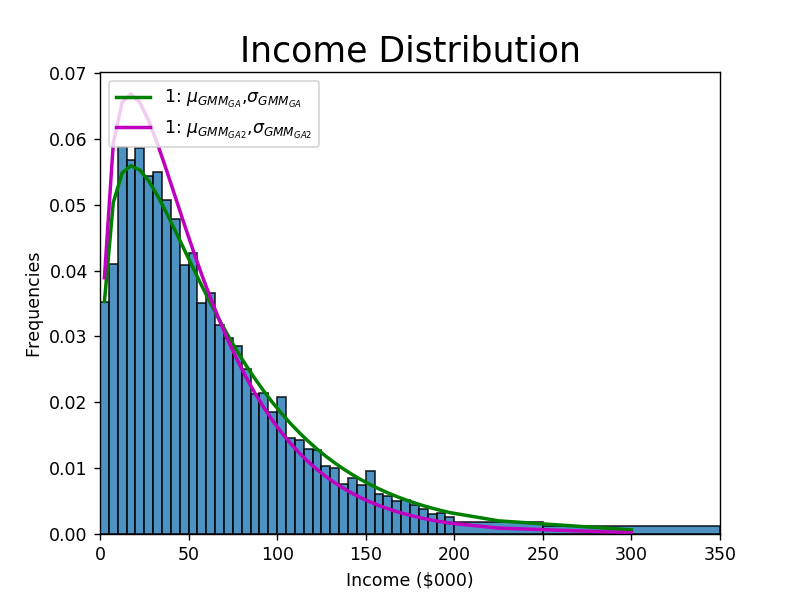

In [498]:
# Plot the histogram of the data
plt.figure(4)
plt.bar(mid_pts/1000, height = np.append(hh_perc[0:40], [hh_perc[40]/10, hh_perc[41]/20]),
        width = np.append([5] * 40, [50, 100]), edgecolor='black', alpha = 0.8)
plt.title('Income Distribution', fontsize=20)
plt.xlim([0, 350])
plt.xlabel('Income ($000)')
plt.ylabel('Frequencies')

# Plot the estimated GMM PDF (c)
plt.plot(mid_pts/1000, np.append(m_model_GA[0:40], [m_model_GA[40]/10, m_model_GA[41]/20]),
         linewidth=2, color='g', label='1: $\mu_{GMM_{GA}}$,$\sigma_{GMM_{GA}}$')
plt.legend(loc='upper left')

# Plot the estimated GMM PDF (new)
plt.plot(mid_pts/1000, np.append(m_model_GA2[0:40], [m_model_GA2[40]/10, m_model_GA2[41]/20]),
         linewidth=2, color='m', label='1: $\mu_{GMM_{GA2}}$,$\sigma_{GMM_{GA2}}$')
plt.legend(loc='upper left')

Comparison:

In [501]:
print('Previously: alpha = ', alpha_GMM_GA, ' beta = ', beta_GMM_GA)
print('With two-step: alpha = ', alpha_GMM_GA2, ' beta = ', beta_GMM_GA2)

Previously: alpha =  1.36290278284  beta =  48295.4442177
With two-step: alpha =  1.44726843981  beta =  37604.6238972


Since we've changed the weighting matrix, it makes no sense to compare the objective function from the minimizations. The parameters have changed and, visually, the new estimation looks worse, which suggests using different moments.

## 2) Brock and Mirman

Brock and Mirman Model:

$$ (c_t)^{-1} - \beta E[r_{t+1}(c_{t+1})^{-1}] = 0 \tag{1} $$ <br>
$$ c_t + k_{t+1} - \omega_t - r_tk_t = 0 \tag{2} $$ <br>
$$ \omega_t - (1 - \alpha)e^{z_t}(k_t)^\alpha = 0 \tag{3} $$ <br>
$$ r_t - \alpha e^{z_t}(k_t)^{\alpha - 1} = 0 \tag{4} $$ <br>
$$ z_t = \rho z_{t-1} + (1 - \rho)\mu + \epsilon_t \tag{5} $$ <br>
$$ \text{where}\: \epsilon_t \sim \mathrm{N}(0, \sigma^2)\: \text{and}\: \alpha,\beta \in (0,1), \: \mu, \sigma > 0, \: \rho \in (-1,1) $$

In [503]:
# importing our data series
macro_data = np.loadtxt('MacroSeries.txt', delimiter = ',')
c_t = macro_data[:,0]
k_t = macro_data[:,1]
omega_t = macro_data[:,2]
r_t = macro_data[:,3]

### Question a)

The idea is to use GMM to estimate the parameters of the model. We'll first define some functions for the minimization routine:

In [534]:
def model_moments_bm(alpha, beta, rho, mu, r_t, k_t, omega_t, c_t):
    '''
    --------------------------------------------------------------------
    This function computes the 4 moment conditions for GMM.
    --------------------------------------------------------------------
    INPUTS:
    params  = (4,) vector, ([alpha, beta, rho, mu])
    alpha   = scalar, 0 < alpha < 1
    beta    = scalar, 0 < beta < 1
    rho     = scalar, -1 < rho < 1
    mu      = scalar > 0
    args    = length 4 tuple, (r_t, k_t, omega_t, c_t)
    r_t     = (N,) vector, interest rate
    k_t     = (N,) vector, capital
    omega_t = (N,) vector, wages
    c_t     = (N,) vector, consumption
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION: None
    
    OBJECTS CREATED WITHIN FUNCTION:
    z_t         = (N,) vector, total factor productivity t
    z_t_fwd     = (N,) vector, total factor productivity t+1
    k_t_fwd     = (N,) vector, capital t+1
    c_t_fwd     = (N,) vector, consumption t+1
    m_1         = moment condition (6)    
    m_2         = moment condition (7)    
    m_3         = moment condition (8)    
    m_4         = moment condition (9)    
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: np.mean(m_1), np.mean(m_2), np.mean(m_3), np.mean(m_4)
    --------------------------------------------------------------------
    '''
    z_t = np.log(r_t/(alpha * (k_t)**(alpha-1)))
    z_t_fwd = np.roll(z_t, -1)
    k_t_fwd = np.roll(k_t, -1)
    c_t_fwd = np.roll(c_t, -1)
        
    m_1 = []
    m_2 = []
    m_3 = []
    m_4 = []
    for i in range(0, np.size(z_t) - 2):
        m_1.append(z_t_fwd[i] - rho * z_t[i] - (1 - rho) * mu) 
        m_2.append((z_t_fwd[i] - rho * z_t[i] - (1 - rho) * mu) * z_t[i])
        m_3.append(beta * alpha * np.exp(z_t_fwd[i]) * (k_t_fwd[i] ** (alpha - 1)) *
                   (c_t[i]/c_t_fwd[i]) - 1) 
        m_4.append((beta * alpha * np.exp(z_t_fwd[i]) * (k_t_fwd[i] ** (alpha - 1)) *
                   (c_t[i]/c_t_fwd[i]) - 1) * omega_t[i]) 
        
    
    return np.mean(m_1), np.mean(m_2), np.mean(m_3), np.mean(m_4)


def err_vec_bm(alpha, beta, rho, mu, r_t, k_t, omega_t, c_t):
    '''
    --------------------------------------------------------------------
    This function computes the vector of moment errors (in percent
    deviation from the data moment vector) for GMM.
    --------------------------------------------------------------------
    INPUTS:
    params  = (4,) vector, ([alpha, beta, rho, mu])
    alpha   = scalar, 0 < alpha < 1
    beta    = scalar, 0 < beta < 1
    rho     = scalar, -1 < rho < 1
    mu      = scalar > 0
    args    = length 4 tuple, (r_t, k_t, omega_t, c_t)
    r_t     = (N,) vector, interest rate
    k_t     = (N,) vector, capital
    omega_t = (N,) vector, wages
    c_t     = (N,) vector, consumption
    simple  = boolean
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        model_moments_bm()
    
    OBJECTS CREATED WITHIN FUNCTION:
    mom_conditions = (4, 1) matrix, column vector of the 4 moment conditions
    err_vec        = (4, 1) matrix, column vector of the 4 moment error
                     functions
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: err_vec
    --------------------------------------------------------------------
    '''
    m_1_mean, m_2_mean, m_3_mean, m_4_mean = model_moments_bm(alpha, beta, rho, mu,
                                                              r_t, k_t, omega_t, c_t)
    err_vec = np.array([[m_1_mean], [m_2_mean], [m_3_mean], [m_4_mean]])
    
    return err_vec


def criterion_bm(params, *args):
    '''
    --------------------------------------------------------------------
    This function computes the GMM weighted sum of squared moment errors
    criterion function value given parameter values and an estimate of
    the weighting matrix.
    --------------------------------------------------------------------
    INPUTS:
    params  = (4,) vector, ([alpha, beta, rho, mu])
    alpha   = scalar, 0 < alpha < 1
    beta    = scalar, 0 < beta < 1
    rho     = scalar, -1 < rho < 1
    mu      = scalar > 0
    args    = length 4 tuple, (r_t, k_t, omega_t, c_t)
    r_t     = (N,) vector, interest rate
    k_t     = (N,) vector, capital
    omega_t = (N,) vector, wages
    c_t     = (N,) vector, consumption
    W_hat   = (R, R) matrix, estimate of optimal weighting matrix
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        err_vec_bm()
    
    OBJECTS CREATED WITHIN FUNCTION:
    err        = (4, 1) matrix, vector of four moment error functions
    crit_val   = scalar > 0, GMM criterion function value
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: crit_val
    --------------------------------------------------------------------
    '''
    alpha, beta, rho, mu = params
    r_t, k_t, omega_t, c_t, W = args
    err = err_vec_bm(alpha, beta, rho, mu, r_t, k_t, omega_t, c_t)
    crit_val = np.dot(np.dot(err.T, W), err) 
    
    return crit_val

Routine: We'll adopt the same strategy as in PS3, meaning we'll first run an unconstrained optimization (but more robust) to get a first approximation (within our bounds) and then run a constrained one.

In [567]:
alpha_init = 0.5
beta_init = 0.2
rho_init = 0.5
mu_init = 2

params_init = np.array([alpha_init, beta_init, rho_init, mu_init])
W_hat = np.eye(4)
gmm_args = (r_t, k_t, omega_t, c_t, W_hat)
#results4 = opt.minimize(criterion_bm, params_init, args=(gmm_args),
#                        method='L-BFGS-B', bounds=((1e-10, 1 - 1e-10), (1e-10, 1 - 1e-10),
#                                                   (-1 + 1e-10, 1 - 1e-10), (1e-10, None)))
results4 = opt.minimize(criterion_bm, params_init, args=(gmm_args),
                       method='Nelder-Mead')
alpha_GMM_BM, beta_GMM_BM, rho_GMM_BM, mu_GMM_BM = results4.x
print('alpha_init=', alpha_init, ' beta_init=', beta_init, ' rho_init=', rho_init,
     ' mu_init=', mu_init)
print('alpha_GMM_BM=', alpha_GMM_BM, ' beta_GMM_BM=', beta_GMM_BM, ' rho_GMM_BM=', rho_GMM_BM,
     ' mu_GMM_BM=', mu_GMM_BM)

alpha_init= 0.5  beta_init= 0.2  rho_init= 0.5  mu_init= 2
alpha_GMM_BM= 0.865414079263  beta_GMM_BM= 0.989999999481  rho_GMM_BM= -0.734176167071  mu_GMM_BM= 2.74225330156


In [568]:
results4

 final_simplex: (array([[ 0.86541408,  0.99      , -0.73417617,  2.7422533 ],
       [ 0.86541442,  0.99      , -0.73417584,  2.74225298],
       [ 0.86541414,  0.99      , -0.73417599,  2.74225319],
       [ 0.86541419,  0.99      , -0.734176  ,  2.74225318],
       [ 0.86541438,  0.99      , -0.73417583,  2.74225305]]), array([ 3.89643033,  3.89648935,  3.89650015,  3.8965089 ,  3.8965248 ]))
           fun: 3.8964303302458037
       message: 'Optimization terminated successfully.'
          nfev: 231
           nit: 129
        status: 0
       success: True
             x: array([ 0.86541408,  0.99      , -0.73417617,  2.7422533 ])

Let's see if we can do better:

In [574]:
params_init = np.array([alpha_GMM_BM-0.2, beta_GMM_BM, rho_GMM_BM, mu_GMM_BM])
W_hat = np.eye(4)
gmm_args = (r_t, k_t, omega_t, c_t, W_hat)
results5 = opt.minimize(criterion_bm, params_init, args=(gmm_args),
                        method='L-BFGS-B', bounds=((1e-10, 1 - 1e-10), (1e-10, 1 - 1e-10),
                                                   (-1 + 1e-10, 1 - 1e-10), (1e-10, None)))
alpha_GMM_BM2, beta_GMM_BM2, rho_GMM_BM2, mu_GMM_BM2 = results5.x
print('alpha_GMM_BM2=', alpha_GMM_BM2, ' beta_GMM_BM2=', beta_GMM_BM2, ' rho_GMM_BM2=',
      rho_GMM_BM2,' mu_GMM_BM2=', mu_GMM_BM2)

alpha_GMM_BM2= 0.667255513553  beta_GMM_BM2= 0.989999996231  rho_GMM_BM2= -0.72565906152  mu_GMM_BM2= 5.67732533676


In [575]:
results5

      fun: array([[ 0.00179391]])
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([  5.16509104e+00,   2.71005716e+05,  -2.28327535e-04,
         2.97851190e-01])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 320
      nit: 28
   status: 0
  success: True
        x: array([ 0.66725551,  0.99      , -0.72565906,  5.67732534])

Estimates:

In [585]:
print('alpha_GMM_BM2 =', alpha_GMM_BM2, ' beta_GMM_BM2 =', beta_GMM_BM2, ' rho_GMM_BM2 =',
      rho_GMM_BM2,' mu_GMM_BM2 =', mu_GMM_BM2)
print('Criterion value = ', results5.fun)

alpha_GMM_BM2 = 0.667255513553  beta_GMM_BM2 = 0.989999996231  rho_GMM_BM2 = -0.72565906152  mu_GMM_BM2 = 5.67732533676
Criterion value =  [[ 0.00179391]]


Is this good? Are those better than the unconstrained ones? Let's plot a bit:

<IPython.core.display.Javascript object>


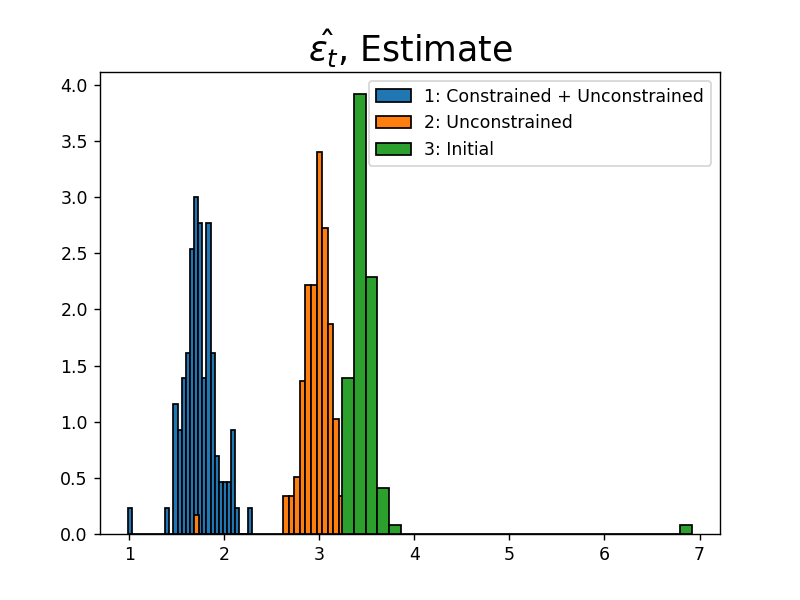

In [593]:
z_t = np.log(omega_t/((1-alpha_GMM_BM2) * (k_t)**alpha_GMM_BM2))
z_t_lag = np.roll(z_t, 1)
z_t_lag[0] = mu_GMM_BM2
eps_t_bm2 = z_t - rho_GMM_BM2 * z_t_lag - (1 - rho_GMM_BM2) * mu_GMM_BM2
plt.figure(5)
count, bins, ignored = plt.hist(eps_t_bm2, 30, edgecolor='black', normed=True, 
                               label='1: Constrained + Unconstrained')
plt.title('$\hat{\epsilon_t}$, Estimate', fontsize=20)

z_t = np.log(omega_t/((1-alpha_GMM_BM) * (k_t)**alpha_GMM_BM))
z_t_lag = np.roll(z_t, 1)
z_t_lag[0] = mu_GMM_BM
eps_t_bm = z_t - rho_GMM_BM * z_t_lag - (1 - rho_GMM_BM) * mu_GMM_BM
plt.figure(5)
count, bins, ignored = plt.hist(eps_t_bm, 30, edgecolor='black', normed=True,
                               label='2: Unconstrained')

z_t = np.log(omega_t/((1-alpha_init) * (k_t)**alpha_init))
z_t_lag = np.roll(z_t, 1)
z_t_lag[0] = mu_init
eps_t_bm3 = z_t - rho_init * z_t_lag - (1 - rho_init) * mu_init
plt.figure(5)
count, bins, ignored = plt.hist(eps_t_bm3, 30, edgecolor='black', normed=True,
                               label='3: Initial')
plt.legend(loc='upper right')

We seem to be closer to our $E[\epsilon_t] = 0$. 